In [3]:
import numpy as np
np.random.seed(21)
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import sexmachine.detector as gender
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("data/users.csv")
    fake_users = pd.read_csv("data/fusers.csv")
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y

def predict_sex(name):
    sex_predictor = gender.Detector(unknown_value=u"unknown",case_sensitive=False)
    first_name= name.str.split(' ').str.get(0)
    sex= first_name.apply(sex_predictor.get_gender)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = sex.map(sex_dict).astype(int)
    return sex_code

def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))   
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code']=predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

print "reading datasets.....\n"
x,y=read_datasets()
x.describe()

print "extracting featues.....\n"
x=extract_features(x)
print x.columns
print x.describe()

reading datasets.....

extracting featues.....

Index([u'statuses_count', u'followers_count', u'friends_count',
       u'favourites_count', u'listed_count', u'sex_code', u'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count     sex_code    lang_code  
count   2818.000000  2818.000000  2818.000000  
mean       2.818666  

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

In [6]:
def build_model():
    model = Sequential()
    model.add(Dense(32, input_dim=7, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
history = keras_model.fit(X_train, y_train, epochs=300, batch_size=60, verbose=1,\
 validation_data=(X_test, y_test))

Train on 704 samples, validate on 1409 samples
Epoch 1/300
704/704 [==============================] - 0s 595us/step - loss: 213.2788 - accuracy: 0.5057 - val_loss: 60.5669 - val_accuracy: 0.8680
Epoch 2/300
704/704 [==============================] - 0s 48us/step - loss: 247.6602 - accuracy: 0.5682 - val_loss: 77.4703 - val_accuracy: 0.9212
Epoch 3/300
704/704 [==============================] - 0s 49us/step - loss: 138.7743 - accuracy: 0.6065 - val_loss: 83.3891 - val_accuracy: 0.9226
Epoch 4/300
704/704 [==============================] - 0s 49us/step - loss: 102.0348 - accuracy: 0.6222 - val_loss: 83.8548 - val_accuracy: 0.9141
Epoch 5/300
704/704 [==============================] - 0s 50us/step - loss: 177.3874 - accuracy: 0.6534 - val_loss: 83.6414 - val_accuracy: 0.9106
Epoch 6/300
704/704 [==============================] - 0s 50us/step - loss: 85.9685 - accuracy: 0.6690 - val_loss: 82.8496 - val_accuracy: 0.9077
Epoch 7/300
704/704 [==============================] - 0s 62us/step - l

In [7]:
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [8]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [9]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    print "False Positive rate: = ", false_positive_rate
    print "True Positive rate: = ", true_positive_rate
    


    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

False Positive rate: =  [0.         0.0030349  0.0030349  0.00758725 0.00758725 0.0091047
 0.0091047  0.01062215 0.01062215 0.01213961 0.01213961 0.01365706
 0.01365706 0.01517451 0.01517451 0.01669196 0.01669196 0.01820941
 0.01820941 0.01972686 0.01972686 0.02124431 0.02124431 0.02124431
 0.02124431 0.02276176 0.02276176 0.02427921 0.02427921 0.02579666
 0.02579666 0.02731411 0.02731411 0.04248862 0.04248862 0.06221548
 0.06221548 0.08801214 0.08801214 0.08952959 0.08952959 0.09104704
 0.09104704 0.09559939 0.09559939 0.09711684 0.09711684 0.10318665
 0.10318665 0.10318665 0.1047041  0.1047041  0.1047041  0.1047041
 0.10622155 0.10622155 0.10925645 0.10925645 0.1107739  0.1107739
 0.11229135 0.11229135 0.1138088  0.1138088  0.1168437  0.1168437
 0.11836115 0.11836115 0.1198786  0.1198786  0.12139605 0.12139605
 0.12291351 0.12291351 0.12594841 0.12594841 0.12594841 0.12594841
 0.12898331 0.12898331 0.13050076 0.13050076 0.13657056 0.13657056
 0.14112291 0.14112291 0.15174507 0.151745

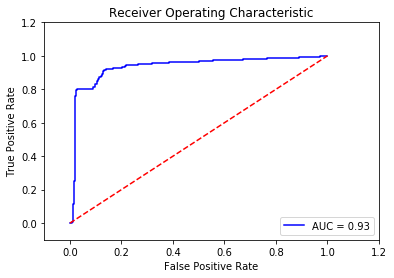

In [10]:
plot_roc_curve(y_test, y_pred_keras)

In [2]:
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
print keras_model.summary()

In [55]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [56]:
# predict probabilities for test set
yhat_probs = keras_model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = keras_model.predict_classes(X_test, verbose=0)

In [57]:

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [58]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.924060
Precision: 0.993921
Recall: 0.863937
F1 score: 0.924382
